<a href="https://colab.research.google.com/github/ananya1512/Movie-Recommender-/blob/master/Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering and Content based movie recommendation system

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import pandas as pd
import numpy as np
from ast import literal_eval
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 407.5 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357251 sha256=2c10b38b9efc3b81f2e3027d814c047b4d1b4e447c6f51e0f2c651309083b8b8
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [3]:
credits = pd.read_csv('/content/drive/MyDrive/movie recomm data/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/movie recomm data/keywords.csv')
links = pd.read_csv('/content/drive/MyDrive/movie recomm data/links_small.csv')
md = pd.read_csv('/content/drive/MyDrive/movie recomm data/movies_metadata.csv')
ratings = pd.read_csv('/content/drive/MyDrive/movie recomm data/ratings_small.csv')


<ipython-input-3-b5d6094b1d0c>:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv('/content/drive/MyDrive/movie recomm data/movies_metadata.csv')


In [4]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [5]:
credits['id'].nunique()

45432

In [6]:
credits.head(2)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844


In [7]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [8]:
keywords['id'].nunique()

45432

In [9]:
keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [10]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [11]:
links.nunique()

movieId    9125
imdbId     9125
tmdbId     9112
dtype: int64

In [12]:
links.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [13]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [14]:
md['id'].nunique()

45436

In [15]:
md.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [17]:
ratings.nunique()

userId         671
movieId       9066
rating          10
timestamp    78141
dtype: int64

In [18]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [19]:
ratings['rating'].max()

5.0

In [20]:
#converting id into int
md['id'] = pd.to_numeric(md['id'], errors='coerce')
md[md['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#removing rows with no id
md = md.dropna(subset=['id'])

In [22]:
# merging md,credits,keywords over id
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [23]:
md.shape

(46628, 27)

In [24]:
#"tmdbId" in links data is represented as "id" in md data
a = links[links['tmdbId'].notnull()]['tmdbId'].astype('int64')
smd=md[md['id'].isin(a)].copy(deep=True)
smd.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords'],
      dtype='object')

In [25]:
smd.shape

(9219, 27)

In [26]:
smd.drop_duplicates(inplace=True)

In [27]:
smd.shape

(9100, 27)

In [28]:
#getting directors name

In [29]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] =smd['crew'].apply(literal_eval)
smd['keywords'] =smd['keywords'].apply(literal_eval)
smd['cast_size'] =smd['cast'].apply(lambda x: len(x))
smd['crew_size'] =smd['crew'].apply(lambda x: len(x))

In [30]:
def getdir(x):
    for i in x:
      if i['department']=='Directing':
        return i['name']
    return np.nan

In [31]:
smd['director'] = smd['crew'].apply(getdir)

In [32]:
smd.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter


In [33]:
#getting genres in a list
smd['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [34]:
smd['genres']=smd['genres'].apply(literal_eval)
smd['genres'][0]

[{'id': 16, 'name': 'Animation'},
 {'id': 35, 'name': 'Comedy'},
 {'id': 10751, 'name': 'Family'}]

In [35]:
def getgenres(x):
    a=[]
    for i in x:
        a.append(i['name'])
    return a

In [36]:

smd['genres'] = smd['genres'].apply(getgenres)

In [37]:
smd['genres'][0]

['Animation', 'Comedy', 'Family']

In [38]:
#getting keywords in a list

In [39]:
smd['keywords'][0]

[{'id': 931, 'name': 'jealousy'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5202, 'name': 'boy'},
 {'id': 6054, 'name': 'friendship'},
 {'id': 9713, 'name': 'friends'},
 {'id': 9823, 'name': 'rivalry'},
 {'id': 165503, 'name': 'boy next door'},
 {'id': 170722, 'name': 'new toy'},
 {'id': 187065, 'name': 'toy comes to life'}]

In [40]:
def getkeywords(x):
    a=[]
    for i in x:
        a.append(i['name'])

    return a

In [41]:
smd['keywords']=smd['keywords'].apply(getkeywords)

In [42]:
smd['keywords'][0]

['jealousy',
 'toy',
 'boy',
 'friendship',
 'friends',
 'rivalry',
 'boy next door',
 'new toy',
 'toy comes to life']

In [43]:
#getting first 3 cast members names in a list

In [44]:
smd['cast'][0][1]

{'cast_id': 15,
 'character': 'Buzz Lightyear (voice)',
 'credit_id': '52fe4284c3a36847f8024f99',
 'gender': 2,
 'id': 12898,
 'name': 'Tim Allen',
 'order': 1,
 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}

In [45]:
def getcast(x):
    a=[]
    for i in x:
        if(len(a)<=2):
            a.append(i['name'])
    return a

In [46]:
smd['cast']=smd['cast'].apply(getcast)
smd['cast'][0]

['Tom Hanks', 'Tim Allen', 'Don Rickles']

In [47]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])    #giving director more importance

In [48]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [49]:
smd['all'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['all'] = smd['all'].apply(lambda x: ' '.join(x))

In [50]:
smd['all'][0]

'jealousi toy boy friendship friend rivalri boynextdoor newtoy toycomestolif tomhanks timallen donrickles johnlasseter johnlasseter johnlasseter Animation Comedy Family'

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=2, stop_words='english')
count_matrix = count.fit_transform(smd['all'])

#since we didnt remove words which occur only ones we set df=2 ,which will remove words which are present in less than 2 movies
#This practise is best for recommender system as we dont need to worry about a single word which only repeates in one movie

In [52]:
count_matrix.shape

(9100, 19855)

In [53]:
from sklearn.metrics.pairwise import  cosine_similarity
cosine_sim = cosine_similarity(count_matrix)

In [54]:
#For content based recommendation system using director,genre,cast and keywords
#cosine_sim tells how simillar two movies are based on its content
cosine_sim[0]

array([1.        , 0.03094922, 0.03333333, ..., 0.        , 0.        ,
       0.        ])

In [55]:
cosine_sim.shape

(9100, 9100)

In [56]:
smd['title']

0                                                Toy Story
1                                                  Jumanji
2                                         Grumpier Old Men
3                                        Waiting to Exhale
4                              Father of the Bride Part II
                               ...                        
40952                       The Last Brickmaker in America
41172                                               Rustom
41225                                         Mohenjo Daro
41391                                        Shin Godzilla
41669    The Beatles: Eight Days a Week - The Touring Y...
Name: title, Length: 9100, dtype: object

In [57]:
smd = smd.reset_index()

In [58]:
smd['title']

0                                               Toy Story
1                                                 Jumanji
2                                        Grumpier Old Men
3                                       Waiting to Exhale
4                             Father of the Bride Part II
                              ...                        
9095                       The Last Brickmaker in America
9096                                               Rustom
9097                                         Mohenjo Daro
9098                                        Shin Godzilla
9099    The Beatles: Eight Days a Week - The Touring Y...
Name: title, Length: 9100, dtype: object

In [59]:
smd.columns

Index(['index', 'adult', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'cast_size',
       'crew_size', 'director', 'all'],
      dtype='object')

In [60]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


In [61]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    fit = np.mean(results['fit_time'])
    test = np.mean(results['test_time'])
    rmse = np.mean(results['test_rmse'])
    algo_name = str(algorithm).split(' ')[0].split('.')[-1]
    series = pd.DataFrame({'test_rmse': rmse,'fit_time': fit,'test_time': test, 'algo': algo_name},index=[0])
    benchmark.append(series)

final_df = pd.concat(benchmark, ignore_index=True)
final_df


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time,algo
0,0.903693,1.559056,0.442957,SVD
1,0.893180,52.588200,14.890681,SVDpp
2,0.941019,3.118724,7.925140,SlopeOne
3,0.961420,2.770632,0.285293,NMF
4,1.442175,0.103973,0.305082,NormalPredictor
5,0.905477,0.425056,3.056120,KNNBaseline
6,0.978563,0.113293,2.137906,KNNBasic
7,0.930156,0.166381,3.134733,KNNWithMeans
8,0.928548,0.237279,2.953254,KNNWithZScore
9,0.897725,0.317512,0.231961,BaselineOnly


from matplotlib import pyplot as plt
final_df['test_rmse'].plot(kind='hist', bins=20, title='test_rmse')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df['fit_time'].plot(kind='hist', bins=20, title='fit_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df['test_time'].plot(kind='hist', bins=20, title='test_time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='test_rmse', y='fit_time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='fit_time', y='test_time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['fit_time']
  ys = series['test_rmse']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_df.sort_values('fit_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fit_time')
_ = plt.ylabel('test_rmse')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['fit_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'fit_time'}, axis=1)
              .sort_values('fit_time', ascending=True))
  xs = counted['fit_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_df.sort_values('fit_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('fit_time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['test_time']
  ys = series['test_rmse']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_df.sort_values('test_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('test_time')
_ = plt.ylabel('test_rmse')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['test_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'test_time'}, axis=1)
              .sort_values('test_time', ascending=True))
  xs = counted['test_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_df.sort_values('test_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('test_time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
final_df['test_rmse'].plot(kind='line', figsize=(8, 4), title='test_rmse')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_df['fit_time'].plot(kind='line', figsize=(8, 4), title='fit_time')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_df['test_time'].plot(kind='line', figsize=(8, 4), title='test_time')
plt.gca().spines[['top', 'right']].set_visible(False)

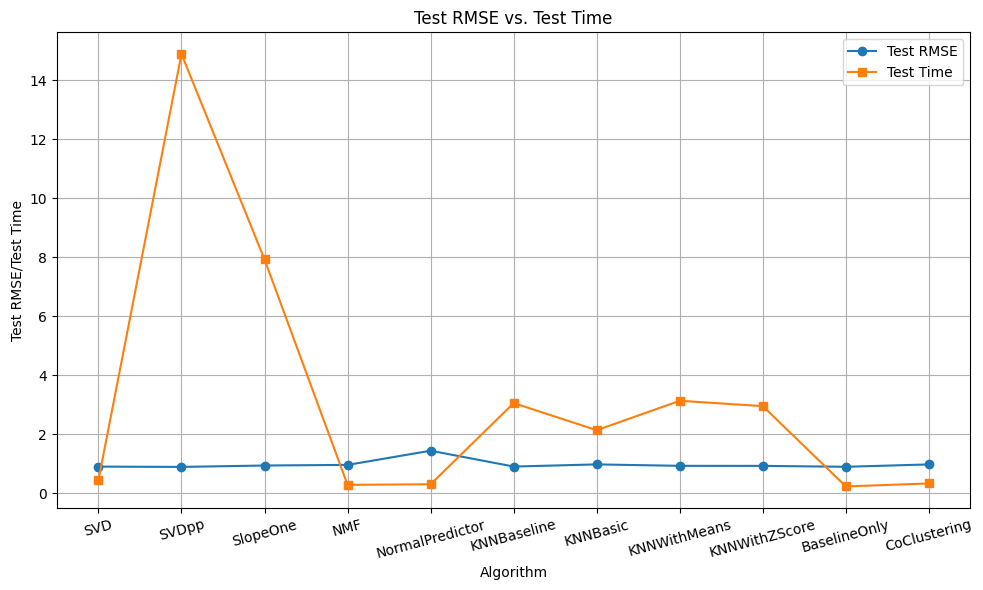

In [73]:
import matplotlib.pyplot as plt
# Create the line chart
plt.figure(figsize=(10, 6))

# Plot test_rmse
plt.plot(final_df['algo'], final_df['test_rmse'], marker='o', label='Test RMSE')

# Plot test_time
plt.plot(final_df['algo'], final_df['test_time'], marker='s', label='Test Time')

# Add labels and title
plt.xlabel('Algorithm')
plt.ylabel('Test RMSE/Test Time')
plt.title('Test RMSE vs. Test Time')

# Add legend
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
# Using collaborative filtering to estimate howmuch a user might rate a movie which they have not rated intitially by
# finding simillar users
svd = SVD()
results=cross_validate(svd, data, measures=['RMSE', 'MAE'])
pd.DataFrame.from_dict(results).mean(axis=0)

test_rmse    0.896096
test_mae     0.689594
fit_time     1.785329
test_time    0.211908
dtype: float64

In [63]:
ratings["movieId"].value_counts()

movieId
356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: count, Length: 9066, dtype: int64

In [64]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [65]:
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])


In [66]:
id_title=links.copy()
id_title.drop('imdbId',axis=1,inplace=True)
id_title.columns=['movieId','id']
id_title=id_title.merge(smd[['title','id']], on='id').set_index('title')
id_index=id_title.set_index('id')


In [67]:
def get_recommendations(userId,title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:25]
    movie_indices = [i[0] for i in sim_scores]
    movie=smd.iloc[movie_indices][['title','id']]
    movie['est']=movie['id'].apply(lambda x: svd.predict(userId, id_index.loc[x]['movieId']).est)
    movie = movie.sort_values('est', ascending=False)
    return movie.head(10)


In [68]:

get_recommendations(1,'The Dark Knight')


,title,id,est
6556,The Prestige,1124.0,3.063262
6157,Batman Begins,272.0,3.040206
8518,Interstellar,157336.0,3.022096
3364,Memento,77.0,2.964110
7567,Inception,27205.0,2.903811
6490,Chaos,5289.0,2.818774
2431,Nighthawks,21610.0,2.770920
5886,Thursday,9812.0,2.769539
5777,Gone in 60 Seconds,16246.0,2.726865
7943,The Dark Knight Rises,49026.0,2.726549


In [69]:
get_recommendations(1, 'Avatar')

,title,id,est
8306,Star Trek Into Darkness,54138.0,3.097955
1939,Mighty Joe Young,39314.0,3.093061
6118,A Trip to the Moon,775.0,3.090824
957,Aliens,679.0,2.952237
522,Terminator 2: Judgment Day,280.0,2.949969
7253,Raiders of the Lost Ark - The Adaptation,62128.0,2.898958
3990,Hawk the Slayer,25628.0,2.830797
7311,The Three Musketeers,140887.0,2.801296
994,The Terminator,218.0,2.792115
905,The Abyss,2756.0,2.774369


In [70]:
get_recommendations(2, 'Avatar')

,title,id,est
522,Terminator 2: Judgment Day,280.0,4.052781
6118,A Trip to the Moon,775.0,4.016294
994,The Terminator,218.0,3.949939
957,Aliens,679.0,3.816300
1799,Six-String Samurai,24746.0,3.813261
1939,Mighty Joe Young,39314.0,3.726355
1359,Titanic,597.0,3.646939
8306,Star Trek Into Darkness,54138.0,3.645436
4923,Hercules in New York,5227.0,3.636253
3990,Hawk the Slayer,25628.0,3.624056
